In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
# sys.path.append(r'E:/0code')
sys.path.append(r'/BIGDATA1/nsccgz_yfdu_1/asc19/wyf/0code/mylearn')
sys.path.append(r'/BIGDATA1/nsccgz_yfdu_1/asc19/wyf/0code')
# sys.path.append('/Users/yanbin/Documents/Projects/AI-Middle-Project/')
# sys.path.append('/Users/yanbin/Documents/Projects/mylearn')

# sys.path.append('/home/wyf/0code/AI-Middle-Project/')
# sys.path.append('/home/wyf/0code/mylearn')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from logger import get_logger
from neural_network import MLPClassifier
from pyml.model_selection import KFold
from pyml.model_selection import ShuffleSplit
from pyml.metrics.classification import precision_score
from pyml.model_selection import KFold
from pyml.model_selection import ShuffleSplit
from pyml.preprocessing import StandardScaler
from pyml.metrics.regression import pearson_correlation
import pickle


mylogger = get_logger(__name__)
mylogger.debug('hello world')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[DEBUG] __init__ __init__.py - pylab_setup line 90 - 
backend module://ipykernel.pylab.backend_inline version unknown
 - (2018-10-21 18:05:15)

[DEBUG] <ipython-input-3-cfa6907cf5eb> <ipython-input-3-cfa6907cf5eb> - <module> line 29 - 
hello world
 - (2018-10-21 18:05:15)



In [2]:
def save_model(model, name):
    with open(name,'wb') as f:
        pickle.dump(model, f)
def load_model(name):
    with open(name,'rb') as f:
        pickle.load(f,model)
    return model

In [3]:
train = pd.read_excel('../data/train.xlsx')
test = pd.read_excel('../data/testStudent.xlsx')

In [4]:
# 增加里tags特征的属性
train = pd.read_excel('../data/train_add_feat_score.xlsx')
test = pd.read_excel('../data/test_add_feat_score.xlsx')

In [5]:
train.dtypes # 检查有没有数据类型错误的，比如原本是int的变成str，说明里面可能有nan值等奇怪的数据

Additional_Number_of_Scoring                    int64
Average_Score                                 float64
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
TripType_score                                  int64
traveler_type_score                             int64
order_type_score                                int64
nights_num_score                                int64
with_pet_score                                  int64
room_type_score                                 int64
dtype: object

In [9]:
# train_ori_X = train.drop('Reviewer_Score', axis=1).drop('Tags', axis=1)
# train_ori_Y = train['Reviewer_Score']
# test_ori_X = test.drop('Tags', axis=1)
train_ori_X = train.drop('Reviewer_Score', axis=1)
train_ori_Y = train['Reviewer_Score'].values
test_ori_X = test

# 特征工程

In [10]:
# 特征方案0：不设置任何特征
train_X_feat = train_ori_X
test_X_feat = test_ori_X

In [11]:
# 查看不同特征与分数的相关系数
for feat_name in train_X_feat:
    print("{} : {}".format(feat_name, pearson_correlation(train_X_feat[feat_name].values, train_ori_Y)))

Additional_Number_of_Scoring : -0.06342829612443443
Average_Score : 0.3622534338191119
Review_Total_Negative_Word_Counts : -0.38232451404246
Total_Number_of_Reviews : -0.0715884558642013
Review_Total_Positive_Word_Counts : 0.22370965918084224
Total_Number_of_Reviews_Reviewer_Has_Given : 0.002496175494613464
TripType_score : 0.11245692676175148
traveler_type_score : 0.08914127698750476
order_type_score : 0.009844120194724183
nights_num_score : 0.027800754327103265
with_pet_score : 0.0008883916547842767
room_type_score : 0.23706243792316262


# 特征归一化

In [12]:
# 方案一：没有权重
ss = StandardScaler()
train_X_standard = ss.fit_transform(train_X_feat.values)
test_X_standard = ss.transform(test_X_feat.values)

# 特征权重设置

In [13]:
# 无

# 交叉验证

In [10]:
train_X_standard = np.load('../best/wyf-train_X-80000-6-standard.npy')

In [6]:
train_X = np.load('../best/wyf-train_X-80000-6-standard.npy')
test_X = np.load('../best/wyf-test_X-30000-6-standard.npy')
train_Y = np.load('../best/wyf-train_Y-80000.npy')

In [7]:
train_X = train_X.T
test_X = test_X.T
train_Y  = train_Y.reshape((-1,1))
train_X.shape,train_Y.shape,test_X.shape

((6, 80000), (80000, 1), (6, 30000))

In [8]:
train_X = pd.DataFrame(train_X)
test_X = pd.DataFrame(test_X)
train_Y = pd.DataFrame(train_Y)
train_X.shape,train_Y.shape,test_X.shape

((6, 80000), (80000, 1), (6, 30000))

In [12]:
learning_rates = [0.5, 0.3, 0.1, 0.05]

n_splits = 1
ms = ShuffleSplit(n_splits=n_splits,test_size=0.2)
models = []
for train_indices, valid_indices in ms.split(train_X_standard):
    for learning_rate in learning_rates:
        train_train_X = train_X.iloc[:,train_indices]
        train_train_Y = train_Y.iloc[train_indices,:]
        train_valid_X = train_X.iloc[:,valid_indices]
        train_valid_Y = train_Y.iloc[valid_indices,:]
        mlpc = MLPClassifier(verbose=False, 
            # 忽略输入和输出层。中间层的结点数。例如 本例子为 input -> 4 -> 2（2分类）
            hidden_layer_sizes=(4,), 
            activation='id', # 'relu', 'sigmoid'. 更多函数，等待支持
            max_iter=500, # 迭代次数
            learning_rate_init=learning_rate, 
            warm_start=True,  # True就好了
            mini_batch='auto', # 保持auto
            step_size=10, # 多少个iteration后，才进行“输出loss”，输出“准确度”，保存模型文件，这三个操作?
            load_from_file=False, # 读文件恢复模型吗
            dump_file=False, # 要不要把模型写入文件？
            validation_set=(train_valid_X, train_valid_Y) # 要不要给一个validation set？（仅用来输出这个集合的准确度)
        )
        mlpc.fit(train_train_X, train_train_Y)
        r = mlpc.score(train_valid_X, train_valid_Y)
        models.append(mlpc)
        print(r)

NotImplementedError: unknown activation id

[DEBUG] font_manager font_manager.py - findfont line 1343 - 
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/GPUFS/app_GPU/anaconda3/5.2.0/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
 - (2018-10-21 11:14:37)



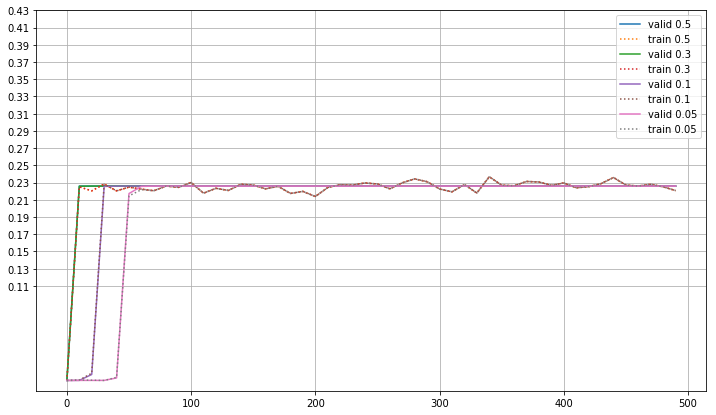

In [31]:
plt.figure(figsize=(12,7)) 
for i,model in enumerate(models):
    m = model.information
    num_iterations = list(m.keys())
    costs = [m[i][0]  for i in num_iterations]
    valid_scores = [m[i][1]  for i in num_iterations]
    train_scores = [m[i][2]  for i in num_iterations]
    plt.plot(num_iterations, valid_scores, '-', label='valid '+ str(learning_rates[i]))
    plt.plot(num_iterations, train_scores, ':', label='train '+ str(learning_rates[i]))
    plt.yticks(np.arange(0.11, 0.45, 0.02))
    ax = plt.gca()
    ax.grid(True)
    plt.legend()